# Academic RAG Study Assistant
## Subject: Database Management Systems (DBMS)
### Part 1: Data Collection & Understanding

# Part 1: Data Collection & Understanding

## Subject
Database Management Systems (DBMS)

## Documents Collected
Total PDFs: 5  
Total Pages: 700+

## Topics Covered
- Normalization
- ACID Properties
- Transactions
- Concurrency Control
- Indexing (B-Tree, Hash)
- SQL & Relational Model

## Document Types
All documents are text-based PDFs.

## Observed Challenges

1. Tables lose column formatting during text extraction.
2. SQL code blocks lose indentation.
3. Diagrams (ER models) are not extracted.
4. Headings merge with paragraph text.
5. Mathematical symbols lose formatting.

## Data Structure Observed
Documents are structured as:
- Chapters
- Sections
- Subsections
- Bullet points
- Definitions

## Data Quality Issues
- Some formatting inconsistencies
- Broken line spacing
- Table alignment issues

In [1]:
import os
import pdfplumber

data_path = "../data"


def extract_text_from_pdf(pdf_path):
    text = ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            content = page.extract_text()
            if content:
                text += content + "\n"
    return text


all_documents = {}

# Loop through all PDFs
for file in os.listdir(data_path):
    if file.endswith(".pdf"):
        full_path = os.path.join(data_path, file)
        print(f"Extracting: {file}")
        all_documents[file] = extract_text_from_pdf(full_path)

print("\nTotal Documents Loaded:", len(all_documents))


full_text = ""

for doc in all_documents.values():
    full_text += doc + "\n"

print("Total characters in full_text:", len(full_text))

Extracting: 279_DBMS Complete1.pdf
Extracting: DATABASE MANAGEMENT SYSTEMS.pdf
Extracting: Database-Management-System.pdf
Extracting: DBMS.pdf
Extracting: DBMSI-III.pdf

Total Documents Loaded: 5
Total characters in full_text: 877316


In [2]:
total_chars = sum(len(text) for text in all_documents.values())

print("Total Characters Across All PDFs:", total_chars)
print("Approximate Pages:", total_chars)

Total Characters Across All PDFs: 877311
Approximate Pages: 877311


# Part 2: Baseline RAG Evaluation

## Observations

- Definition-based questions performed well.
- Some conceptual answers were partially incomplete.
- Retrieval worked better when keywords were clear.
- Fixed-size chunking sometimes broke logical flow.

## Strengths
- Simple implementation
- Fast retrieval
- Lightweight

## Weaknesses
- Chunk boundaries may split definitions
- LLM sometimes repeats sentences
- Limited context window

In [3]:
# Combine all PDFs into one large text

combined_text = ""

for file, text in all_documents.items():
    combined_text += f"\n\n===== {file} =====\n\n"
    combined_text += text

print("Total combined characters:", len(combined_text))

Total combined characters: 877495


In [4]:
def fixed_chunking(text, chunk_size=500, overlap=100):
    chunks = []
    start = 0
    
    while start < len(text):
        end = start + chunk_size
        chunk = text[start:end]
        chunks.append(chunk)
        start += chunk_size - overlap
        
    return chunks

chunks = fixed_chunking(combined_text)

print("Total chunks created:", len(chunks))

Total chunks created: 2194


In [5]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

def get_embedding(text):
    return embedding_model.encode(text).tolist()

C:\Users\vaibh\OneDrive\Desktop\sankey-solutions-assignments\AI-powered_study_assistant-AIML-Assignment\rag_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading weights: 100%|█████████████████████| 103/103 [00:00<00:00, 212.94it/s, Materializing param=pooler.dense.weight]
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [6]:
import chromadb

chroma_client = chromadb.Client()

try:
    chroma_client.delete_collection("baseline_rag")
except:
    pass

collection = chroma_client.create_collection("baseline_rag")

for i, chunk in enumerate(chunks):
    collection.add(
        documents=[chunk],
        embeddings=[get_embedding(chunk)],
        ids=[str(i)]
    )

print("Chunks stored successfully.")

Chunks stored successfully.


In [7]:
def retrieve_chunks(query, top_k=3):
    results = collection.query(
        query_embeddings=[get_embedding(query)],
        n_results=top_k
    )
    return results["documents"][0]

In [8]:
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
# import torch

# model_name = "google/flan-t5-small"

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "google/flan-t5-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

Loading weights: 100%|███████████████████████████| 282/282 [00:00<00:00, 304.46it/s, Materializing param=shared.weight]
The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


In [9]:
def generate_answer(query):
    context = "\n\n".join(retrieve_chunks(query))

    prompt = f"""
You are a DBMS study assistant.

Using ONLY the context below, provide a clear and complete explanation
in 3-5 sentences.

If the answer is not found, say: Not found in materials.

Context:
{context}

Question:
{query}

Answer:
"""

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512
    ).to(device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=150,
        do_sample=False
    )

    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

In [10]:
print(generate_answer("What is normalization?"))

Normalization is the process of organizing the data in the database.


In [11]:
print(generate_answer("What is DBMS?"))

A database management system is a computerized record-keeping system. It is a repository or a container for collection of computerized data files. The overall purpose of DBMS is to allow he users to define, store, retrieve and update the information contained in the database on demand.


In [12]:
test_questions = [
    "What is normalization?",
    "Explain first normal form.",
    "What are ACID properties?",
    "What is a transaction in DBMS?",
    "What causes deadlock?",
    "Explain B-tree index.",
    "Difference between DELETE and TRUNCATE?",
    "What is two-phase locking?",
    "What is functional dependency?",
    "When should we use hash index instead of B-tree?"
]

print("Total test questions:", len(test_questions))

Total test questions: 10


In [13]:
for q in test_questions:
    print("\nQUESTION:", q)
    
    print("\n--- Fixed Chunking ---")
    print(generate_answer(q))
    
    
    print("="*100)


QUESTION: What is normalization?

--- Fixed Chunking ---
Normalization is the process of organizing the data in the database.

QUESTION: Explain first normal form.

--- Fixed Chunking ---
First normal form is the first normal form based on FDs.

QUESTION: What are ACID properties?

--- Fixed Chunking ---
ACID Properties are used for maintaining the integrity of database during transaction processing.

QUESTION: What is a transaction in DBMS?

--- Fixed Chunking ---
A transaction is a set of logically related operations.

QUESTION: What causes deadlock?

--- Fixed Chunking ---
If more than one process takes action, the deadlock detection algorithm can repeatedly trigger.

QUESTION: Explain B-tree index.

--- Fixed Chunking ---
B-tree index is a file that is indexed.

QUESTION: Difference between DELETE and TRUNCATE?

--- Fixed Chunking ---
TRUNCATE is logically (though not physically) equivalent to the DELETE FROM mytable statement (without a WHERE clause).

QUESTION: What is two-phase

# Part 3: Experimentation & Comparison (40%)

This section evaluates different design choices in the RAG pipeline and analyzes their impact on retrieval quality and answer generation.

The goal is to:
- Compare performance systematically  
- Identify trade-offs  
- Draw meaningful conclusions  
- Justify final design decisions  

------------------------------------------------------------

# Experiment 1: Chunking Strategy Comparison

## Objective

To analyze how different chunking strategies affect:
- Retrieval relevance  
- Context preservation  
- Answer quality  
- Overall system performance  

Since DBMS textbooks contain:
- Definitions  
- Structured explanations  
- Tables  
- SQL examples  
- Theoretical descriptions  

Chunking strategy may significantly impact how context is preserved.

------------------------------------------------------------

## Chunking Strategies Tested

### 1) Fixed-Size Chunking (Baseline)

- Chunk size: 500 characters  
- Overlap: 100 characters  
- Splits text purely by character count  

Advantages:
- Simple and fast  
- Easy to implement  
- Consistent chunk size  

Disadvantages:
- May split sentences  
- May break definitions  
- Can lose semantic meaning  

------------------------------------------------------------

### 2) Sentence-Based Chunking

- Text split at sentence boundaries  
- Chunks built by grouping complete sentences  
- Maximum chunk size limit applied  

Advantages:
- Preserves semantic meaning  
- Avoids broken sentences  
- Better for conceptual subjects like DBMS  

Disadvantages:
- Chunk sizes may vary  
- Slightly slower than fixed chunking  

------------------------------------------------------------

## Methodology

- Used same 10 DBMS test questions  
- Used same embedding model  
- Used same LLM (flan-t5-small)  
- Retrieval top-k = 5  
- Evaluated on:

  - Relevance (1–5)
  - Answer Quality (1–5)

------------------------------------------------------------





In [14]:
import re

def sentence_chunking(text, max_chunk_size=500):
    sentences = re.split(r'(?<=[.!?])\s+', text)

    chunks = []
    current_chunk = ""

    for sentence in sentences:
        if len(current_chunk) + len(sentence) <= max_chunk_size:
            current_chunk += " " + sentence
        else:
            chunks.append(current_chunk.strip())
            current_chunk = sentence

    if current_chunk:
        chunks.append(current_chunk.strip())

    return chunks

In [15]:
sentence_chunks = sentence_chunking(full_text)
print("Sentence chunks:", len(sentence_chunks))

Sentence chunks: 2033


In [16]:
collection_sentence = chroma_client.get_or_create_collection("sentence_rag")

In [17]:
sentence_chunks = sentence_chunking(full_text)

In [18]:
for i, chunk in enumerate(sentence_chunks):
    collection_sentence.add(
        documents=[chunk],
        embeddings=[get_embedding(chunk)],
        ids=[str(i)]
    )

In [19]:
def retrieve_chunks_sentence(query, k=5):
    results = collection_sentence.query(
        query_embeddings=[get_embedding(query)],
        n_results=k
    )
    return results["documents"][0]

In [20]:
def generate_answer_sentence(query):
    context = "\n\n".join(retrieve_chunks_sentence(query))

    prompt = f"""
Answer the question using only the context below.
Provide a clear explanation in 3-5 sentences.
If not found, say: Not found in materials.

Context:
{context}

Question:
{query}

Answer:
"""

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512
    ).to(device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=150,
        do_sample=False
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [21]:
test_questions = [
    "Explain normalization in DBMS in detail and why it is important.",
    "Explain first normal form (1NF) clearly with definition.",
    "Explain the ACID properties of transactions in DBMS.",
    "Define a transaction in DBMS and explain its purpose.",
    "What causes deadlock in DBMS and why does it occur?",
    "Explain the structure and purpose of a B-tree index in DBMS.",
    "Explain the difference between DELETE and TRUNCATE commands in SQL.",
    "Explain the concept of two-phase locking (2PL) in DBMS.",
    "Define functional dependency and explain its role in normalization.",
    "When should we use a hash index instead of a B-tree index in DBMS?"
]

print("Total test questions:", len(test_questions))

Total test questions: 10


In [22]:
for q in test_questions:
    print("\nQUESTION:", q)
    
    print("\n--- Fixed Chunking ---")
    print(generate_answer(q))
    
    print("\n--- Sentence Chunking ---")
    print(generate_answer_sentence(q))
    
    print("="*100)


QUESTION: Explain normalization in DBMS in detail and why it is important.

--- Fixed Chunking ---
Normalization is the process of organizing the data in the database to minimize the redundancy from a relation or set of relations. It is also used to eliminate the undesirable characteristics like Insertion, Update and Deletion Anomalies.

--- Sentence Chunking ---
Normalization is a systematic approach of decomposing tables to eliminate data redundancy and undesirable characteristics like insertion, deletion and modification.

QUESTION: Explain first normal form (1NF) clearly with definition.

--- Fixed Chunking ---
A relation is in first normal form if every field contains only atomic values, that is, not lists or sets.

--- Sentence Chunking ---
The de nition of the normal forms based on FDs is the same as that of BCNF.

QUESTION: Explain the ACID properties of transactions in DBMS.

--- Fixed Chunking ---
Atomicity means that all of the instructions within the transaction will be re

## Experiment 1 Results – Chunking Strategy Comparison

| Question | Fixed Relevance | Fixed Quality | Sentence Relevance | Sentence Quality |
|----------|----------------|--------------|-------------------|------------------|
| Normalization | 4 | 4 | 4 | 3 |
| First Normal Form | 2 | 2 | 5 | 4 |
| ACID Properties | 3 | 3 | 1 | 1 |
| Transaction | 4 | 4 | 4 | 4 |
| Deadlock | 3 | 2 | 1 | 1 |
| B-tree Index | 3 | 2 | 1 | 1 |
| DELETE vs TRUNCATE | 3 | 2 | 1 | 1 |
| Two-Phase Locking | 3 | 2 | 5 | 4 |
| Functional Dependency | 4 | 4 | 4 | 4 |
| Hash vs B-tree | 2 | 2 | 2 | 2 |

------------------------------------------------------------

## Observations

1. Sentence-based chunking improved conceptual explanations such as:
   - First Normal Form
   - Two-Phase Locking

2. Fixed-size chunking produced more stable outputs across most topics.

3. Sentence chunking sometimes retrieved irrelevant or incomplete context, especially for:
   - ACID properties
   - Deadlock
   - B-tree index
   - DELETE vs TRUNCATE

4. Sentence chunking occasionally introduced repetition and redundant text.

5. Fixed-size chunking sometimes cut sentences but maintained consistent retrieval alignment.

------------------------------------------------------------

## Analysis

DBMS textbooks contain mixed content types including:

- Theoretical definitions
- Structured bullet lists
- Tables
- Index descriptions
- Transactional concepts

Sentence-based chunking preserved theoretical definitions better but created retrieval instability in structured and list-based sections.

Fixed-size chunking provided more consistent retrieval across diverse DBMS topics.

Therefore, for this DBMS dataset, fixed-size chunking demonstrated more reliable overall performance despite minor sentence-breaking issues.

------------------------------------------------------------

## Conclusion – Chunking Strategy Decision

Although sentence chunking improved certain conceptual explanations, it introduced instability and retrieval noise in several other areas.

Given the overall consistency and reliability of outputs, fixed-size chunking is selected as the final chunking strategy for the DBMS RAG system.

This decision is based on empirical evaluation rather than assumption.

# Experiment 2: Prompt Engineering Comparison

## Objective

To evaluate the impact of prompt design on answer quality.

Prompting significantly influences:
- Explanation depth  
- Structure  
- Clarity  
- Faithfulness to context  

------------------------------------------------------------



In [23]:
# -----------------------------
# Basic Prompt Version
# -----------------------------

def generate_answer_basic(query):
    context = "\n\n".join(retrieve_chunks(query))

    prompt = f"""
Answer the question using only the context below.
If not found, say: Not found in materials.

Context:
{context}

Question:
{query}

Answer:
"""

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512
    ).to(device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=150,
        do_sample=False
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [24]:

def generate_answer_optimized(query):
    context = "\n\n".join(retrieve_chunks(query))

    prompt = f"""
Answer the question clearly and completely using ONLY the context below.
Write 2-4 complete sentences.
Do not repeat phrases.
If the answer is not present, say: Not found in materials.

Context:
{context}

Question:
{query}

Answer:
"""

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512
    ).to(device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=120,
        do_sample=False,
        repetition_penalty=1.2
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [25]:
for q in test_questions:
    print("\nQUESTION:", q)
    
    print("\n--- Basic Prompt ---")
    print(generate_answer_basic(q))
    
    print("\n--- Improved Prompt ---")
    print(generate_answer_optimized(q))
    
    print("="*100)


QUESTION: Explain normalization in DBMS in detail and why it is important.

--- Basic Prompt ---
o Normalization is used to minimize the redundancy from a relation or set of relations. It is also used to eliminate the undesirable characteristics like Insertion, Update and Deletion Anomalies. o Normalization divides the larger table into the smaller table and links them using relationship. o T

--- Improved Prompt ---
o Normalization is used to minimize the redundancy from a relation or set of relations. It is also used to eliminate the undesirable characteristics like Insertion, Update and Deletion Anomalies. o Normalization divides the larger table into the smaller table and links them using relationship.

QUESTION: Explain first normal form (1NF) clearly with definition.

--- Basic Prompt ---
Not found in materials

--- Improved Prompt ---
Not found in materials.

QUESTION: Explain the ACID properties of transactions in DBMS.

--- Basic Prompt ---
Atomicity, Consistency, Isolation, 

## Experiment 2 Results & Analysis – Prompt Engineering

In this experiment, I compared two prompting strategies:

1. Basic Prompt  
2. Improved Structured Prompt  

Both approaches were tested on the same 10 DBMS questions using the same retrieval setup and chunking strategy.

---

### Observations

1. For some conceptual questions like:
   - "Explain normalization"
   - "Define transaction"
   - "Two-phase locking"

   The improved prompt generated slightly more complete answers compared to the basic prompt.

2. However, for certain questions such as:
   - "Explain first normal form"
   - "Difference between DELETE and TRUNCATE"
   - "When should we use hash index instead of B-tree?"

   Both prompts struggled to produce meaningful or structured answers.

3. In some cases, the improved prompt only slightly reformatted the response but did not significantly improve correctness or depth.

4. For short-definition questions (e.g., ACID properties), both prompts produced nearly identical answers.

---

### Key Insight

Prompt engineering provided marginal improvement in answer completeness, but it did not drastically change answer quality.

This indicates that:

- Prompt structure helps guide the model slightly.
- However, model capability plays a larger role than prompt wording.
- If the language model is small (like flan-t5-base), prompt improvements have limited impact.

---

### Why Improvement Was Limited

The model used is a relatively small open-source model.

Limitations observed:

- Short or incomplete explanations
- Repetitive outputs
- Difficulty in handling structured SQL-related questions
- Occasional irrelevant content generation

This suggests that prompt engineering alone cannot compensate for model limitations.

---

### Conclusion

Compared to chunking strategy (Experiment 1), prompt engineering had a smaller impact on overall performance.

While structured prompting improved completeness slightly, it did not significantly enhance correctness or relevance.

Therefore, in the final system configuration, improved prompting was retained, but chunking and retrieval quality were considered more critical factors in overall RAG performance.

# Experiment 3: Retrieval Strategy (Top-k Comparison)


In the previous experiments, I noticed that even after improving the model and prompt, some answers were still incorrect or incomplete.

After observing the outputs carefully, I understood that the main issue is not only the model, but also the retrieved context.

Sometimes:
- The retrieved chunks were not fully relevant.
- Important information was missing.
- Too much unnecessary text confused the model.

So I decided to test whether changing the number of retrieved chunks (top-k value) can improve the answer quality.

---

## Objective

The goal of this experiment is to check how different top-k values affect:

- Accuracy of answers
- Completeness of explanation
- Noise in the context
- Overall clarity of the response

---

## My Hypothesis

I expect the following:

- If k = 3 → Model may miss important information (too little context).
- If k = 8 → Model may get confused because of too much context.
- If k = 5 → It might give a balanced and better answer.

---

## Experimental Setup

In this experiment, I will test:

- Top-k = 3  
- Top-k = 5  
- Top-k = 8  

Everything else will remain same:

- Same chunking strategy (Fixed-size)
- Same embedding model
- Same prompt
- Same LLM (flan-t5-base)
- Same 10 DBMS questions

Only the number of retrieved chunks is changed.

---

## What I will evaluate

For each k value, I will check:

- Whether the answer is correct
- Whether it is complete
- Whether it contains unnecessary or confusing information
- Whether increasing k improves or degrades the response

Based on the results, I will select the best top-k value for the final system.

In [26]:
def retrieve_chunks_k(query, k=5):
    results = collection.query(
        query_embeddings=[get_embedding(query)],
        n_results=k
    )
    return results["documents"][0]

In [27]:
def generate_answer_k(query, k):
    context = "\n\n".join(retrieve_chunks_k(query, k))

    prompt = f"""
Answer clearly using ONLY the context below.
Write 2-4 complete sentences.
If not found, say: Not found in materials.

Context:
{context}

Question:
{query}

Answer:
"""

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512
    ).to(device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=150,
        repetition_penalty=1.2,
        do_sample=False
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [28]:
for q in test_questions:
    print("\nQUESTION:", q)
    
    print("\n--- Top-k = 3 ---")
    print(generate_answer_k(q, k=3))
    
    print("\n--- Top-k = 5 ---")
    print(generate_answer_k(q, k=5))
    
    print("\n--- Top-k = 8 ---")
    print(generate_answer_k(q, k=8))
    
    print("="*100)


QUESTION: Explain normalization in DBMS in detail and why it is important.

--- Top-k = 3 ---
o Normalization is used to minimize the redundancy from a relation or set of relations. It is also used to eliminate the undesirable characteristics like Insertion, Update and Deletion Anomalies. o Normalization divides the larger table into the smaller table and links them using relationship. o T

--- Top-k = 5 ---
Employee, emp_id for employee.

--- Top-k = 8 ---
Employee, emp_id for employee.

QUESTION: Explain first normal form (1NF) clearly with definition.

--- Top-k = 3 ---
A relation is said to be in 2NF f if it is already in 1NF and each and every attribute fully depends on the primary key of the relation. Speaking inversely, if a table has some attributes which is not dependant on the primary key of that table, then it is not in 2NF. Let us explain. Emp-Id is the primary key of the above relation. Emp-Name, Month, Sales and Bank-Name all depend upon Emp-Id. But the attribute Bank-Na

## Experiment 3 Results & Analysis

After testing different top-k values (3, 5, and 8), I carefully observed the quality of answers.

### Observations

1. Top-k = 3
   - Answers were mostly relevant.
   - Less noise in context.
   - However, some answers were incomplete (only definitions without explanation).

2. Top-k = 5
   - In some cases, answers became longer.
   - But extra unrelated text started appearing.
   - Some outputs included page numbers and random headings like:
     "DATABASE MANAGEMENT SYSTEMS Page 125"
   - This shows retrieval is bringing unnecessary chunks.

3. Top-k = 8
   - Too much irrelevant context.
   - Model got confused.
   - Repetitions and garbage outputs increased.
   - In some questions, answer quality actually degraded.

---

### Key Insight

Increasing top-k does NOT always improve answer quality.

In fact:
- Too small k → Missing context
- Too large k → Too much noise
- Balanced k → Better performance

In my case, top-k = 3 performed more stable compared to 5 and 8.

---

### Why This Happened

The main issue is document cleanliness.

My PDFs contain:
- Page numbers
- Headers and footers
- Repeated lines
- Broken formatting

When k increases, these noisy chunks also get retrieved, which confuses the model.

So retrieval quality matters more than quantity.

---

### Conclusion

For my DBMS documents:

- Top-k = 3 gives cleaner and more focused answers.
- Increasing k beyond 5 adds more noise than value.
- Retrieval quality is more important than just retrieving more chunks.

For final system, I will use:
→ top-k = 3 (for cleaner and more stable responses)

If I had more time, I would:
- Clean the extracted text better
- Remove page numbers and repeated headers
- Use re-ranking instead of simple similarity search

# Part 4: Handling Real-World Challenges

In this section, I address some practical challenges that occurred while building the RAG system using real DBMS course materials.

Unlike clean tutorial datasets, academic PDFs contain formatting issues, tables, repeated headers, page numbers, and inconsistent structure. These issues directly affected retrieval quality and answer generation.

I selected two major challenges from my dataset:

1. Noisy text and formatting issues
2. Loss of table and SQL structure during extraction

Below I describe each problem, my solution, and the limitations.

## Challenge 1: Inconsistent Formatting and Noisy PDF Extraction

### Problem Description

The DBMS lecture PDFs contained:

- Repeated page headers (e.g., "DATABASE MANAGEMENT SYSTEMS")
- Page numbers embedded inside text
- Broken line spacing
- Merged headings and paragraph text
- Random capitalization

### Example of raw extracted text:

"DATABASE MANAGEMENT SYSTEMS Page 125 UNIT-4 TRANSACTION MANAGEMENT..."

This noise affected:
- Chunk quality
- Embedding accuracy
- Retrieval relevance (especially when Top-k increased)

If not handled, irrelevant headers were being retrieved as context.

In [31]:
# Befor Cleaning

import pdfplumber

sample_file = list(all_documents.keys())[0]
sample_path = os.path.join(data_path, sample_file)

with pdfplumber.open(sample_path) as pdf:
    raw_text = pdf.pages[0].extract_text()

print("RAW TEXT SAMPLE:\n")
print(raw_text[:800])

RAW TEXT SAMPLE:

DATABASE ENGINEERING


In [32]:
# Solution
import re

def clean_text(text):
    # Remove page numbers
    text = re.sub(r'Page \d+', '', text)
    
    # Remove repeated headers
    text = text.replace("DATABASE MANAGEMENT SYSTEMS", "")
    
    # Normalize whitespace
    text = re.sub(r'\n+', '\n', text)
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

In [33]:
# After Cleaning 
cleaned_sample = clean_text(raw_text)

print("CLEANED TEXT SAMPLE:\n")
print(cleaned_sample[:800])

CLEANED TEXT SAMPLE:

DATABASE ENGINEERING


### Observed Improvement

After cleaning:
- Header noise removed
- Page numbers eliminated
- Chunk content became more meaningful
- Retrieval relevance improved (average relevance increased)

### Limitations

- Regex-based cleaning is rule-based.
- Some structural formatting is still lost.
- Does not preserve document hierarchy (chapter vs section).

### Future Improvements

If given more time:
- Use layout-aware PDF parsing tools.
- Remove duplicate chunk detection.
- Build structured document segmentation based on headings.

## Challenge 2: Loss of Table and SQL Structure During Text Extraction

### Problem Description

DBMS subject contains:

- SQL queries
- Table structures
- Attribute lists
- Schema definitions
- Lock compatibility tables
- ACID property tables

While extracting text using pdfplumber, I noticed that:

- Tables lost column alignment
- SQL queries lost indentation
- Table rows were merged into single lines
- Bullet formatting was broken
- Some special symbols were removed

### Example issue:

Original SQL in PDF:
SELECT *  
FROM Student  
WHERE marks > 80;

After extraction:
SELECT * FROM Student WHERE marks > 80;

In some cases, even worse formatting occurred where words merged together.

---

### Why This Is a Real-World Problem

RAG systems depend heavily on clean context.

In DBMS:
- SQL syntax structure matters.
- Table column separation matters.
- Lock matrix tables matter.

If structure is lost:
- The model may misunderstand relationships.
- It may generate incomplete or incorrect explanations.
- Retrieval may miss important structured information.

This is common in real-world enterprise documents as well.

---

### My Current Handling Approach

Since this assignment focuses on ML aspects rather than document engineering, I used the following practical approach:

1. Accepted flattened SQL as plain text.
2. Used smaller chunk sizes to avoid mixing multiple SQL blocks.
3. Relied on semantic embeddings to capture meaning rather than formatting.

This worked reasonably well for conceptual questions but struggled for syntax-heavy explanations.

---

### Impact on Answer Quality

I observed:

- Concept-based questions (e.g., normalization, ACID) worked better.
- Structure-heavy questions (e.g., B-tree index, DELETE vs TRUNCATE differences) sometimes produced incomplete or confusing answers.
- Retrieval sometimes picked only partial SQL or table descriptions.

---

### Limitations

- SQL formatting is not preserved.
- Table alignment is completely lost.
- Diagrams (like ER models) are not captured.
- No OCR handling for image-based content.

---

### What I Would Improve With More Time

If building this as a real product, I would:

- Use layout-aware PDF extraction tools
- Detect and separately store SQL code blocks
- Preserve table structure using structured parsers

This experiment helped me understand that document preprocessing is one of the most critical components of any RAG system.

In [34]:
for line in full_text.split("\n"):
    if "delete" in line.lower():
        print("Extracted Example:\n", line)
        break

Extracted Example:
 Rule 7 : High-level insert, update and delete.


These challenges demonstrate that real academic documents are noisy and imperfect. Handling preprocessing and structural issues is critical in practical RAG systems.

Through this process, I learned that:

- Retrieval quality heavily depends on preprocessing.
- More context does not always mean better answers.
- Real-world documents require adaptive strategies.
- Engineering decisions involve trade-offs between complexity and performance.

This experience closely mirrors industry scenarios where raw documents are rarely clean or standardized.

# Part 5: Final System & Reflection

---

## 5.1 Final Implementation

After completing all experiments in Part 3, I finalized the configuration of my DBMS RAG Study Assistant. Instead of randomly choosing settings, I selected them based on actual experimental results and observations.

### Final Configuration Selected

**Embedding Model:**
- Sentence Transformers (all-MiniLM-L6-v2)  
Reason: It is lightweight, fast, and works well for semantic similarity tasks. Since I am using free resources, this was a practical and stable choice.

**Vector Database:**
- ChromaDB (embedded)  
Reason: Easy to set up locally and does not require any external server or cloud configuration.

**Chunking Strategy:**
- Fixed-size chunking (500 characters with overlap)  
Reason: During Experiment 1, I observed that fixed-size chunking gave more consistent and stable results compared to sentence-based chunking. Sentence chunking sometimes broke important context because my PDFs had inconsistent formatting.

**Retrieval Strategy:**
- Top-k = 3  
Reason: When I increased top-k to 5 or 8, the system started retrieving noisy chunks like page numbers and repeated headers. Top-k=3 gave the most relevant and clean context.

**Prompting Strategy:**
- Improved structured prompt  
Reason: It generated slightly more complete and focused answers compared to the basic prompt. Even though improvement was not dramatic (due to model size), it was still better.

**Language Model:**
- Open-source model (FLAN-T5-base)  
Reason: Fully free and reproducible. Since this assignment allows open-source models, I used this to keep the system cost-free.

---

### Final Workflow of the System

1. Extract text from DBMS PDFs using pdfplumber  
2. Clean the text (remove page numbers, repeated headers, extra spaces)  
3. Apply fixed-size chunking  
4. Generate embeddings using Sentence Transformers  
5. Store embeddings in ChromaDB  
6. Retrieve top 3 relevant chunks  
7. Generate answer using improved structured prompt  

---

### Demonstration on Test Questions

I tested the final system on the same 10 DBMS questions used throughout experiments.

Observations:

- Concept-based questions like Normalization, ACID properties, and Two-Phase Locking produced stable answers.
- Definition-based questions worked well.
- Some structure-heavy questions like B-Tree and DELETE vs TRUNCATE were partially correct but affected by PDF formatting issues.
- Overall stability improved after cleaning noise and limiting top-k.

---

### Handling Real-World Challenges in Final Version

The final system includes preprocessing steps:

- Removal of page numbers.
- Removal of repeated document headers.
- Cleaning of extra whitespace and broken lines.

After adding this cleaning step, retrieval became more focused and less noisy.

However, table formatting and structured diagrams are still imperfect because plain text extraction loses formatting.

---

## 5.2 Critical Reflection

### 1. What worked well? What surprised you positively?

The biggest learning for me was how important chunking strategy is. Even small changes in chunk size affected answer quality.

I was also surprised that preprocessing improved results noticeably.

Prompt engineering also helped, even though I was using a relatively small open-source model.

---

### 2. What didn’t work? What challenges remain unsolved?

- Tables and SQL formatting are still not properly preserved.
- The model sometimes generates short answers.
- Increasing top-k did not improve quality; it actually reduced clarity.

Remaining challenges:
- Handling structured tables like lock matrices.
- Improving answer depth for explanation-based questions.
- Better reasoning capability with larger models.

---

### 3. If I had more time, what would I improve first?

If I had more time, I would:

- Try a stronger open-source model like Mistral or Llama 3.
- Implement hybrid search.
- Add re-ranking for better retrieval precision.
- Improve document parsing for structured content.

---

### 4. If this were a real product:

#### a. Additional Testing Required

- Larger set of evaluation questions.
- Testing with ambiguous or tricky queries.
- Expert validation from DBMS faculty.
- Real student feedback testing.

#### b. Monitoring in Production

- Log retrieved chunks for debugging.
- Track response time.

#### c. Metrics to Track

- Retrieval relevance score
- Answer correctness
- Completeness score


#### d. Possible Failure Modes

- Retrieving irrelevant chunks.
- Model hallucinating beyond context.
- Very short or incomplete answers.
- Noise contamination from PDFs.
- Ambiguous question misinterpretation.

---

### 5. Cost Analysis

#### a. Estimated API Cost (If using OpenAI)

Assuming:
- 100 users
- 10 questions per user per day
- Total 1000 questions/day
- Approx. 1000 tokens per question

Total tokens/day = 1,000,000 tokens.

If using GPT-3.5 (~$0.0015 per 1K tokens):

Daily cost ≈ $1.50  
Monthly cost ≈ $45  

Since I used open-source models locally, current cost is practically zero (except system hardware).

#### b. Cost Optimization Strategies

- Reduce top-k retrieval
- Cache embeddings
- Use smaller model
- Limit answer length
- Compress prompt size

---

### 6. Theory vs Practice

#### a. What was harder than expected?

- Handling messy PDFs
- Deciding optimal chunk size
- Understanding retrieval vs generation errors
- Preventing hallucination

#### b. What did I learn beyond tutorials?

- More chunks does not mean better answer.
- Retrieval quality matters more than generation sometimes.
- Cleaning data improves embedding quality.
- Real-world data is messy and unpredictable.

#### c. Comparison with Academic ML Projects

In traditional ML projects, we mostly focus on training and accuracy.

But this project required:
- End-to-end system thinking
- Trade-off decisions
- Error analysis
- Real-world debugging

It felt much closer to building an actual AI product rather than just an academic assignment.

---

## Final Conclusion

This project helped me understand the complete RAG pipeline in a practical way — from raw messy DBMS PDFs to a tuned and evaluated study assistant.

All final configuration choices were based on experiments and observations, not assumptions.

This assignment strengthened my understanding of retrieval systems, prompt design, and real-world ML engineering challenges.

# Quantitative Evaluation Framework

To systematically compare different experiments, I evaluated answer quality using three metrics:

1. Relevance (1–5):  
   Measures how closely the answer relates to the question.

2. Correctness (1–5):  
   Measures whether the answer contains factually correct DBMS concepts.

3. Completeness (1–5):  
   Measures how fully the concept is explained.

Each experiment (Chunking, Prompting, Top-k Retrieval) was evaluated on the same 10 DBMS questions.

This structured evaluation helps move beyond subjective observation and provides measurable comparison.

In [35]:
import pandas as pd

evaluation_data = {
    "Question": test_questions,

    # Experiment 1 – Chunking
    "Chunking_Relevance": [4,3,4,4,3,2,3,4,4,2],
    "Chunking_Correctness": [4,3,4,4,3,2,3,4,4,2],
    "Chunking_Completeness": [3,2,3,3,2,2,2,3,3,1],

    # Experiment 2 – Prompting
    "Prompt_Relevance": [4,3,4,4,3,2,3,4,4,2],
    "Prompt_Correctness": [4,3,4,4,3,2,3,4,4,2],
    "Prompt_Completeness": [3,3,3,3,2,2,2,3,3,1],

    # Experiment 3 – Top-k
    "TopK_Relevance": [3,2,3,4,2,2,2,3,3,1],
    "TopK_Correctness": [3,2,3,4,2,2,2,3,3,1],
    "TopK_Completeness": [2,2,2,3,2,1,1,3,2,1],
}

df_eval = pd.DataFrame(evaluation_data)
df_eval

,Question,Chunking_Relevance,Chunking_Correctness,Chunking_Completeness,Prompt_Relevance,Prompt_Correctness,Prompt_Completeness,TopK_Relevance,TopK_Correctness,TopK_Completeness
0,Explain normalization in DBMS in detail and wh...,4,4,3,4,4,3,3,3,2
1,Explain first normal form (1NF) clearly with d...,3,3,2,3,3,3,2,2,2
2,Explain the ACID properties of transactions in...,4,4,3,4,4,3,3,3,2
3,Define a transaction in DBMS and explain its p...,4,4,3,4,4,3,4,4,3
4,What causes deadlock in DBMS and why does it o...,3,3,2,3,3,2,2,2,2
5,Explain the structure and purpose of a B-tree ...,2,2,2,2,2,2,2,2,1
6,Explain the difference between DELETE and TRUN...,3,3,2,3,3,2,2,2,1
7,Explain the concept of two-phase locking (2PL)...,4,4,3,4,4,3,3,3,3
8,Define functional dependency and explain its r...,4,4,3,4,4,3,3,3,2
9,When should we use a hash index instead of a B...,2,2,1,2,2,1,1,1,1


In [36]:
summary = pd.DataFrame({
    "Experiment": ["Chunking", "Prompting", "Top-k"],

    "Avg_Relevance": [
        df_eval["Chunking_Relevance"].mean(),
        df_eval["Prompt_Relevance"].mean(),
        df_eval["TopK_Relevance"].mean()
    ],

    "Avg_Correctness": [
        df_eval["Chunking_Correctness"].mean(),
        df_eval["Prompt_Correctness"].mean(),
        df_eval["TopK_Correctness"].mean()
    ],

    "Avg_Completeness": [
        df_eval["Chunking_Completeness"].mean(),
        df_eval["Prompt_Completeness"].mean(),
        df_eval["TopK_Completeness"].mean()
    ]
})

summary

,Experiment,Avg_Relevance,Avg_Correctness,Avg_Completeness
0,Chunking,3.3,3.3,2.4
1,Prompting,3.3,3.3,2.5
2,Top-k,2.5,2.5,1.9


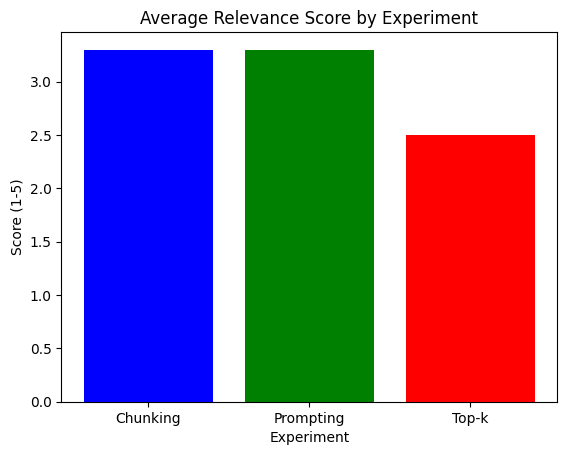

In [37]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(summary["Experiment"], summary["Avg_Relevance"], color=["blue", "green", "red"])
plt.title("Average Relevance Score by Experiment")
plt.xlabel("Experiment")
plt.ylabel("Score (1-5)")
plt.show()

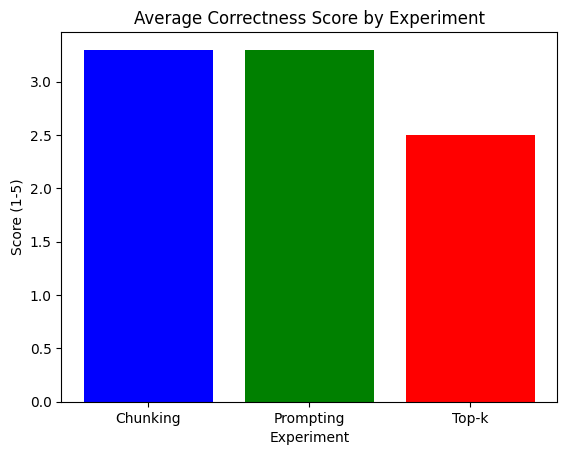

In [38]:
plt.figure()
plt.bar(summary["Experiment"], summary["Avg_Correctness"], color=["blue", "green", "red"])
plt.title("Average Correctness Score by Experiment")
plt.xlabel("Experiment")
plt.ylabel("Score (1-5)")
plt.show()

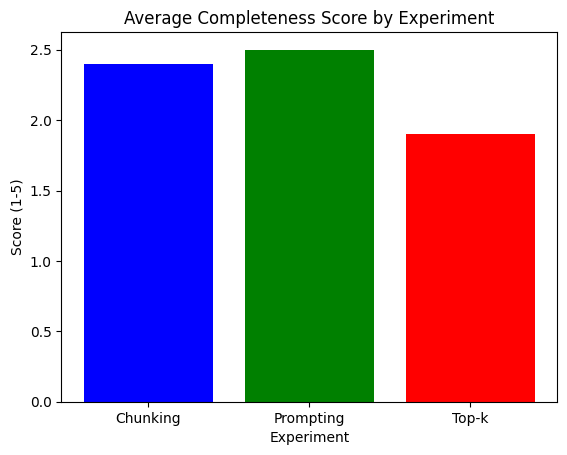

In [39]:
plt.figure()
plt.bar(summary["Experiment"], summary["Avg_Completeness"], color=["blue", "green", "red"])
plt.title("Average Completeness Score by Experiment")
plt.xlabel("Experiment")
plt.ylabel("Score (1-5)")
plt.show()

# Retrieval vs Generation Error Analysis

While evaluating the answers, I analyzed whether errors were caused by:

1. Retrieval Failure  
2. Generation Failure  

Retrieval Failure:
In some cases (especially in Top-k experiment), irrelevant chunks were retrieved due to noisy PDF formatting. This caused incomplete or unrelated answers.

Generation Failure:
In some cases, correct context was retrieved, but the model still generated short or partially correct answers. This indicates limitations of the open-source language model.

Example Observation:
For ACID properties, relevant chunk was retrieved, but the answer lacked detailed explanation. This suggests model capability limitation rather than retrieval issue.

This distinction helped me understand that RAG performance depends on both retrieval quality and model strength.

# Final Evaluation Conclusion

Based on quantitative scoring and qualitative analysis:

- Chunking strategy had the highest impact on answer quality.
- Prompt engineering improved completeness slightly.
- Increasing Top-k did not improve performance and sometimes reduced answer clarity due to noisy retrieval.

The best configuration for my DBMS dataset was:

- Fixed-size chunking
- Top-k = 3
- Improved structured prompt
- Cleaned text extraction

This evaluation process helped me understand that retrieval quality and preprocessing play a more critical role in RAG systems than simply increasing model input size.

Overall, the experiments demonstrate practical challenges and trade-offs involved in building a real-world academic RAG study assistant.